# Código referente ao Exercícios 4 e 5

In [1]:
import uproot # abrir os arquivos .root
import numpy as np # colocar os dados no formato conhecido como numpy
import matplotlib.pyplot as plt # fazer os graficos
import mplhep as hep # responsável por algumas partes que envolve altas energias e estilização padrão do CMS e LHC
import seaborn as sns # para realizar estátisticas
import math # funções matemáticas

In [2]:
plt.style.use(hep.style.ROOT) # deixar os gráficos em formato rootianos por padrão do CMS

In [3]:
myfile = uproot.open( 'Skim4.root' )
tree = myfile['oniaTree']
tree.keys()
data = tree['dimuon_p4'].array()

In [4]:
lista_massa = []
lista_pt    = []
lista_eta   = []
for i in range( 0 , data.size ):
    lista_massa.append( data[i].mass ) # preenchendo a lista vazia das massas com o atributo massa do TLorentzVector  
    lista_pt.append( data[i].pt ) # preenchendo a lista vazia do momentum transverso com o atributo pt do TLorentzVector  
    lista_eta.append( data[i].eta ) # preenchendo a lista vazia das pseudorapidez com o atributo eta do TLorentzVector

In [5]:
lista_massa = np.array( lista_massa )
lista_pt = np.array( lista_pt )
lista_eta = np.array( lista_eta )

In [6]:
lista_massa_cut = (lista_massa < 12) & (lista_massa > 7) # limites para o pico do méson Upsilon 
lista_massa_Upsi = lista_massa[lista_massa_cut]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


Text(10.2, 160, '$\\Upsilon$(3S)')

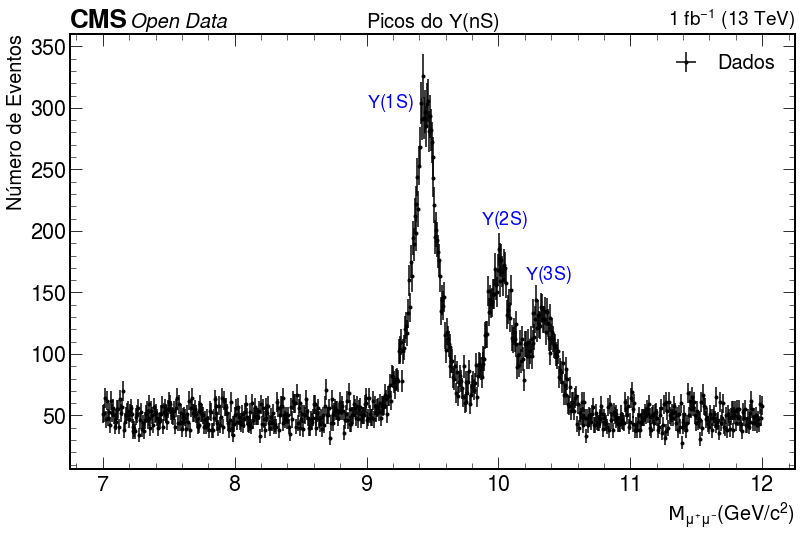

In [7]:
plt.figure( figsize = ( 13, 8 ) )

counts_1, bin_edges_1 = np.histogram( lista_massa_Upsi , bins = np.linspace( 7, 12, 700 ) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
plt.errorbar( bin_centres_1, counts_1, 
              yerr = errors_1, 
              xerr=abs(bin_centres_1[4] - bin_centres_1[5])/2 , 
              fmt = '.', 
              label = 'Dados', color = 'black' )

plt.xlabel( r'$\mathcal{M}_{\mu^{+}\mu^{-}}$(GeV/c$^{2}$)', fontsize = 20)
plt.ylabel( 'Número de Eventos',fontsize = 20)
hep.cms.label( llabel = "Open Data", rlabel = "1 fb$^{-1}$ (13 TeV)", fontsize = 20)
plt.title( r"Picos do $\Upsilon$(nS)" , fontsize = 20 )
plt.legend( loc = 'best', fontsize = 20 )
plt.text(9.,300, r'$\Upsilon$(1S)', fontsize = 18 , color = 'blue')
plt.text(9.87,205, r'$\Upsilon$(2S)', fontsize = 18 , color = 'blue')
plt.text(10.2,160, r'$\Upsilon$(3S)', fontsize = 18 , color = 'blue')

In [8]:
xmin , xmax = 8.5 , 9.86 # intervalo do pico escolhido

In [9]:
corte_pt = 0

lista_pt_cut = (lista_pt > corte_pt) # corte do pt maior que 5 GeV

lista_massa_pt = lista_massa[lista_pt_cut]
lista_pt_after_cut = lista_pt[lista_pt_cut]
lista_eta_pt = lista_eta[lista_pt_cut]

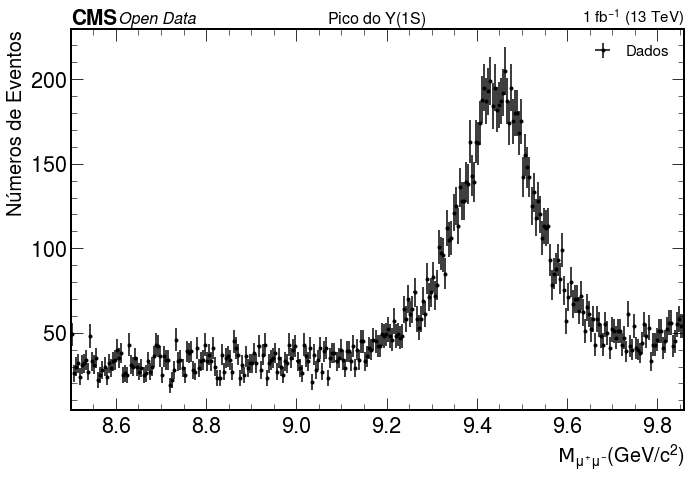

In [10]:
lista_massa_cut = ( lista_massa_pt < xmax ) & ( lista_massa_pt > xmin ) # intervalo de massa característico do pico do méson Upsilon(1S) 
lista_massa_fit = lista_massa_pt[ lista_massa_cut ]

plt.figure(figsize=(11,7))

counts_1, bin_edges_1 = np.histogram( lista_massa_fit , bins=np.linspace(xmin,xmax,300))
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
plt.errorbar(bin_centres_1, counts_1, 
             yerr = errors_1, xerr = abs(bin_centres_1[4] - bin_centres_1[5])/2,
             fmt='.', label = 'Dados', color = 'black')

plt.xlabel(r"$\mathcal{M}_{\mu^{+}\mu^{-}}(GeV/c^{2})$", fontsize = 20)
plt.ylabel('Números de Eventos',fontsize = 20)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,3), useMathText = True)
hep.cms.label(llabel="Open Data", rlabel="1 fb$^{-1}$ (13 TeV)", fontsize = 16)
plt.title(r"Pico do $\Upsilon(1S)$ " , fontsize = 16)
plt.legend(loc='best',fontsize = 15)
plt.xlim(xmin,xmax)
plt.style.use(hep.style.ROOT)

In [11]:
import zfit

In [12]:
obs = zfit.Space("x", limits=(xmin, xmax) )
massa = zfit.Parameter("massa", 9.5, 9.1 , 9.7)
sigma = zfit.Parameter("sigma", 0.2, 0.01 , 1)
alpha = zfit.Parameter("alpha", 3, 1 , 20)
n = zfit.Parameter("n", 0.2, 0.01 , 1)
coeffs = zfit.Parameter("coeffs", 0.2, -1 , 1)
frac = zfit.Parameter("fraction", 0.2, -3 , 10)

In [13]:
color = 'black' # cor para fazer os plots
n_bins = 50 

linewidth = 2.5 
plot_scaling = lista_massa_fit.size / n_bins * obs.area() # fator de correção das pdf's

x = np.linspace(xmin, xmax, lista_massa_fit.size)
data = zfit.Data.from_numpy( obs = obs, array = lista_massa_fit ) # colocar os dados em formato zfit

<ipython-input-13-ad9cbc5b8a6f>:5: UserWarning: The function <function Space.area at 0x7f16cc1a9e50> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[8.5]]), array([[9.86]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plot_scaling = lista_massa_fit.size / n_bins * obs.area() # fator de correção das pdf's


In [14]:
crystall_ball = zfit.pdf.CrystalBall(mu=massa, sigma=sigma, alpha=alpha, n=n, obs=obs, name='CrystalBall')
hermite = zfit.pdf.Hermite(obs = obs, coeffs = coeffs)
modelo = zfit.pdf.SumPDF([crystall_ball, hermite], fracs = frac)

In [15]:
nll_crystall_ball = zfit.loss.UnbinnedNLL(model=crystall_ball, data=data)
nll_hermite = zfit.loss.UnbinnedNLL(model=hermite, data=data)
nll_modelo = zfit.loss.UnbinnedNLL(model=modelo, data=data)

In [16]:
minimizer = zfit.minimize.Minuit()

In [17]:
result_modelo = minimizer.minimize(nll_modelo)
param_errors_modelo, _ = result_modelo.errors()

/home/matheus/miniconda3/lib/python3.8/site-packages/zfit/models/polynomials.py:27: UserWarning: The function <function Space.limit1d at 0x7f16cc1ab0d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=(0,), limits=(array([[8.5]]), array([[9.86]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lim_low, lim_high = limits.limit1d


------------------------------------------------------------------
| FCN = 1834                    |     Ncalls=281 (281 total)     |
| EDM = 0.000179 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/home/matheus/miniconda3/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:358: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


In [18]:
for var, errors in param_errors_modelo.items():
    print('{}: ^{{+{}}}_{{{}}}'.format(var.name, errors['upper'], errors['lower']))

fraction: ^{+0.006708256004375508}_{-0.006730696955308257}
alpha: ^{+9.626543314932597}_{-9.626543314932597}
massa: ^{+0.0015944656594077955}_{-0.0015944656594077955}
n: ^{+0.7801612898151168}_{-0.7801612898151168}
sigma: ^{+0.0017446974505954532}_{-0.0017446974505954532}
coeffs: ^{+0.009097750712612158}_{-0.009270443590548978}


In [19]:
params = result_modelo.params

In [20]:
massa_fit = params[massa]['value']
print('Massa do fit --> ', massa_fit)
sigma_fit = params[sigma]['value']
print('Sigma do fit --> ', sigma_fit)

Massa do fit -->  9.444012105501887
Sigma do fit -->  0.08868162552507722


In [21]:
massa.set_value(massa_fit)
sigma.set_value(sigma_fit)
coeffs.set_value(params[coeffs]['value'])
n.set_value(params[n]['value'])
frac.set_value(params[frac]['value'])

(8.8, 9.86)

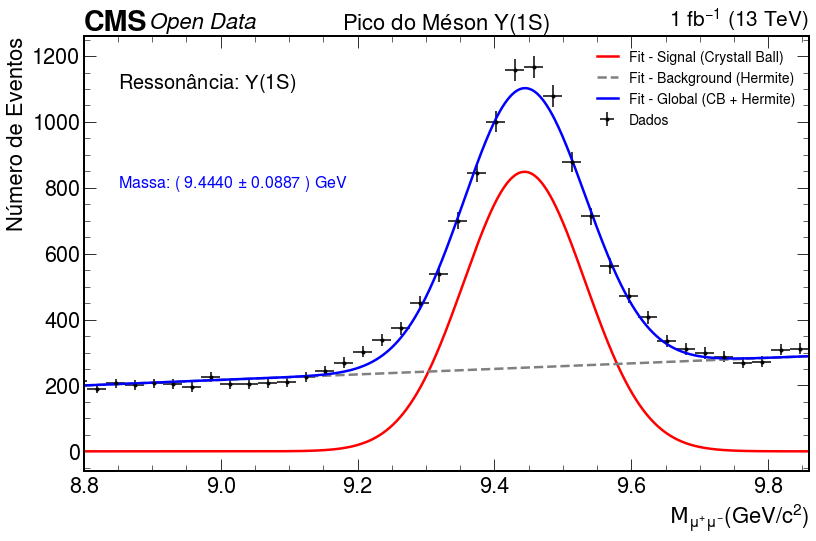

In [32]:
plt.figure(figsize = ( 13, 8 ))

counts_1, bin_edges_1 = np.histogram( lista_massa_fit , bins=np.linspace(xmin,xmax,n_bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
plt.errorbar(bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[4] - bin_centres_1[5])/2,fmt='.', label = 'Dados', color = 'black')

plt.text(8.85,1100, r"Ressonância: $\Upsilon$(1S)", color = 'black', fontsize = 20)
plt.text(8.85,800, "Massa: ( {:2.4f} $\pm$ {:2.4f} ) GeV".format(massa_fit , sigma_fit ), color = 'blue', fontsize = 16)
#plt.text(8.85,700,"com: ({:2.3f} $\pm$ {:2.3f} ) MeV".format(1.600 ,1.700), color = 'blue', fontsize = 16)

# plot the pdfs
y_crystall_ball = ( crystall_ball.pdf(x) * frac ).numpy()  
y_hermite = ( hermite.pdf(x) * ( 1 - frac ) ).numpy()  
y_modelo = ( modelo.pdf(x) ).numpy()  

plt.plot(x, y_crystall_ball*plot_scaling , '-', label="Fit - Signal (Crystall Ball)", linewidth=linewidth, color = 'red')
plt.plot(x, y_hermite*plot_scaling , '--', label="Fit - Background (Hermite)", linewidth=linewidth, color = 'gray')
plt.plot(x, y_modelo*plot_scaling , '-', label="Fit - Global (CB + Hermite)", linewidth=linewidth, color = 'blue')

hep.cms.label( llabel="Open Data" , rlabel="1 fb$^{-1}$ (13 TeV)" , fontsize = 22 )

plt.xlabel(r"$\mathcal{M}_{\mu^{+}\mu^{-}}(GeV/c^{2})$", fontsize = 22 )
plt.ylabel( 'Número de Eventos' , fontsize = 22 )
plt.title( r'Pico do Méson $\Upsilon$(1S)' , fontsize = 22 )
plt.legend(loc='best',fontsize = 14 )
plt.style.use(hep.style.ROOT)
plt.xlim(8.8,xmax)

# Número de Eventos --> Integral entre a linha azul e a pontilhada cinza

In [23]:
integrate = ( modelo.integrate(limits=(8.8, xmax)) - hermite.integrate(limits=(8.8, xmax)) ).numpy()

In [24]:
n_eventos = integrate*len(x)
print( 'Número de Eventos extraido do fit --> ', int(n_eventos[0]) )
print( 'Massa Invariante --> ', massa_fit, 'GeV' )

Número de Eventos extraido do fit -->  1236
Massa Invariante -->  9.444012105501887 GeV
